# Overview

1. [__Importing data__](#1)
    1. [Loading csv files](#1.1)


2. [__Preprocessing data__](#2)
    1. [Droping NaNs](#2.1)
    2. [Cleaning dataset](#2.2)
    3. [Datetime](#2.3)
    4. [Selecting data (2018-2022)](#2.4)


3. [__Trial plots__](#3)
    1. [Number of 112 incidents per Catalonia regions](#3.1)
        1. [Províncies](#3.1.1)
        2. [Comarques](#3.1.2)
        3. [Municipis](#3.1.3)
        
    2. [Time evolution of 112 incidents](#3.2)
        1. [Grouped by províncies](#3.2.1)
        2. [Grouped by typology](#3.2.2)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from datetime import datetime


# 1. Importing data <a class="anchor" id="1"></a>

In [2]:
data_dir = "../dades/"
fig_dir = "figures/"

## 1.1. Loading csv files <a class="anchor" id="1.1"></a>

In [3]:
rescue_actions = pd.read_csv(data_dir+"Actuacions_en_salvaments_al_medi_natural_dels_Bombers_de_la_Generalitat_20231109.csv")
protection_plans = pd.read_csv(data_dir+"Registre_general_de_plans_de_protecci__civil_de_Catalunya_20231109.csv")
inc_112 = pd.read_csv(data_dir+"Dades_d_incidents_operatius_gestionats_pel_CAT112_20231110.csv")


https://analisi.transparenciacatalunya.cat/Seguretat/Actuacions-en-salvaments-al-medi-natural-dels-Bomb/fsum-2k6e
https://analisi.transparenciacatalunya.cat/Seguretat/Registre-general-de-plans-de-protecci-civil-de-Cat/xqqe-tgav
https://analisi.transparenciacatalunya.cat/Seguretat/Dades-d-incidents-operatius-gestionats-pel-CAT112/jq8m-d7cw
https://analisi.transparenciacatalunya.cat/Seguretat/Dades-de-trucades-operatives-gestionades-pel-CAT11/mfqb-sbx4

In [4]:
comarques = ["Alt Camp","Alt Empordà","Alt Penedès","Alt Urgell","Alta Ribagorça","Anoia","Aran","Bages","Baix Camp",
             "Baix Ebre","Baix Empordà","Baix Llobregat","Baix Penedès","Barcelonès","Berguedà","Cerdanya",
             "Conca de Barberà","Garraf","Garrigues","Garrotxa","Gironès","Maresme","Moianès","Montsià",
             "Noguera","Osona","Pallars Jussà","Pallars Sobirà","Pla d'Urgell","Pla de l'Estany","Priorat",
             "Ribera d'Ebre","Ripollès","Segarra","Segrià","Selva","Solsonès","Tarragonès","Terra Alta",
             "Urgell","Vallès Occidental","Vallès Oriental"]

# 2. Preprocessing data <a class="anchor" id="2"></a>

## 2.1. Dropping NaNs <a class="anchor" id="2.1"></a>

We only conserve data from Municipal Plans to study them geographically

In [5]:
rescue_actions.dropna(axis=0, inplace=True)
protection_plans.dropna(axis=0, inplace=True)
inc_112.dropna(axis=0, inplace=True)


In [6]:
rescue_actions = rescue_actions.reset_index().drop("index",axis=1)
protection_plans = protection_plans.reset_index().drop("index",axis=1)
inc_112 = inc_112.reset_index().drop("index",axis=1)


# 2.2. Cleaning dataset <a class="anchor" id="2.2"></a>

In [7]:
inc_112.columns

Index(['ANY', 'MES', 'PROVINCIA', 'COMARCA', 'MUNICIPI', 'TIPUS', 'INCIDENTS'], dtype='object')

In [8]:
inc_112

,ANY,MES,PROVINCIA,COMARCA,MUNICIPI,TIPUS,INCIDENTS
0,2023,10,BARCELONA,VALLES OCCIDENTAL,TERRASSA,Seguretat,1
1,2023,10,BARCELONA,Vallès Oriental,LLIÇA D'AMUNT,Accident,2
2,2023,10,GIRONA,Garrotxa,OLOT,Incendi,6
3,2023,10,TARRAGONA,Baix Camp,ALMOSTER,Incendi,1
4,2023,10,BARCELONA,Berguedà,CASTELLAR DEL RIU,Seguretat,2
...,...,...,...,...,...,...,...
507684,2014,1,GIRONA,ALT EMPORDA,CAPMANY,Seguretat,1
507685,2014,1,GIRONA,SELVA,VIDRERES,Incendi,4
507686,2014,1,GIRONA,PLA DE L'ESTANY,CRESPIA,Incendi,1
507687,2014,1,GIRONA,ALT EMPORDA,LLANÇA,Seguretat,13


In [9]:
tipus_inc = inc_112["TIPUS"].unique()
tipus_inc

array(['Seguretat', 'Accident', 'Incendi', 'Fuita (aigua, gas, altres)',
       'Meteorologia', 'Altres incidències', 'Assistència sanitària',
       'Civisme', 'Trànsit', 'Medi ambient'], dtype=object)

## 2.3. Datetime <a class="anchor" id="2.3"></a>

In [10]:
inc_112['ANY'] = inc_112['ANY'].astype(int)
inc_112['MES'] = inc_112['MES'].astype(int)

In [11]:
inc_112['datetime'] = inc_112.apply(lambda inc_112: datetime(inc_112['ANY'], inc_112['MES'], 1), axis=1)
inc_112 = inc_112.drop(["ANY","MES"], axis=1)

## 2.4. Selecting data from 2018 to 2022 <a class="anchor" id="2.4"></a>

In [12]:
inc_112 = inc_112[(inc_112["datetime"].dt.year >= 2018) & (inc_112["datetime"].dt.year <= 2022)].reset_index()


## 2.5. Selecting plans related to protection plans & rescue actions <a class="anchor" id="2.5"></a>

In [13]:
inc_112["TIPUS"].unique()

array(['Incendi', 'Altres incidències', 'Assistència sanitària',
       'Medi ambient', 'Accident', 'Trànsit', 'Civisme', 'Seguretat',
       'Fuita (aigua, gas, altres)', 'Meteorologia'], dtype=object)

In [14]:
inc_selected = ["Incendi","Accident","Meteorologia","Assistència sanitària"]

inc_112 = inc_112[inc_112["TIPUS"].isin(inc_selected)]

In [15]:
inc_112

,index,PROVINCIA,COMARCA,MUNICIPI,TIPUS,INCIDENTS,datetime
0,50174,TARRAGONA,CONCA DE BARBERA,SANTA COLOMA DE QUERALT,Incendi,1,2022-12-01
1,50175,LLEIDA,PLA D'URGELL,BELL-LLOC D'URGELL,Incendi,1,2022-12-01
3,50177,BARCELONA,VALLES ORIENTAL,SANT FELIU DE CODINES,Incendi,1,2022-12-01
4,50178,GIRONA,CERDANYA,GUILS DE CERDANYA,Assistència sanitària,2,2022-12-01
6,50180,GIRONA,SELVA,SANTA COLOMA DE FARNERS,Accident,1,2022-12-01
...,...,...,...,...,...,...,...
265524,315698,GIRONA,GIRONES,SANT GREGORI,Assistència sanitària,11,2018-01-01
265526,315700,BARCELONA,BAIX LLOBREGAT,MARTORELL,Accident,3,2018-01-01
265527,315701,TARRAGONA,TARRAGONES,LA SECUITA,Assistència sanitària,8,2018-01-01
265534,315708,BARCELONA,BAGES,SANT MATEU DE BAGES,Incendi,1,2018-01-01


# 3. Trial plots <a class="anchor" id="3"></a>

In [16]:
font = 12

## 3.1 Number of protection plans activated per Catalonia regions <a class="anchor" id="3.1"></a>

### 3.1.1. Províncies <a class="anchor" id="3.1.1"></a>

In [17]:
cat_prov = gpd.read_file("cat/provincies/divisions-administratives-v2r1-provincies-100000-20230928.shx")
cat_prov

,CODIPROV,NOMPROV,CAPPROV,AREAP5000,geometry
0,08,Barcelona,Barcelona,7730.5077,"MULTIPOLYGON (((386943.411 4561257.965, 386961..."
1,17,Girona,Girona,5902.1773,"MULTIPOLYGON (((482690.024 4613155.364, 482688..."
2,25,Lleida,Lleida,12165.5722,"MULTIPOLYGON (((393371.457 4638570.630, 393374..."
3,43,Tarragona,Tarragona,6305.7083,"MULTIPOLYGON (((298299.980 4494128.520, 298299..."


In [18]:
inc_112.replace("BARCELONA","Barcelona", inplace=True)
inc_112.replace("LLEIDA","Lleida", inplace=True)
inc_112.replace("TARRAGONA","Tarragona", inplace=True)
inc_112.replace("GIRONA","Girona", inplace=True)

In [19]:
ninc_prov = inc_112.groupby('PROVINCIA').size().reset_index(name='# incidents')

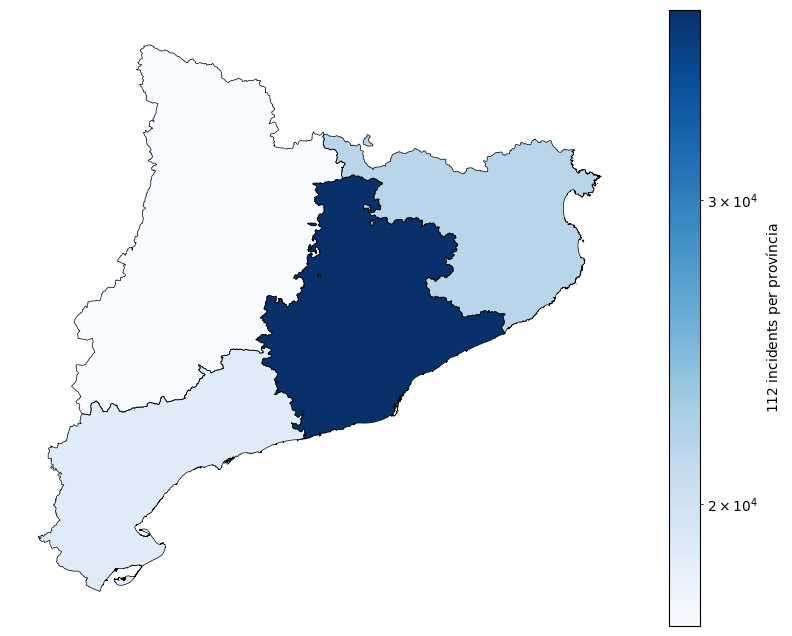

In [20]:
# Merge between shapefile & data
ninc_prov_merge = cat_prov.merge(ninc_prov, how='left', left_on='NOMPROV', right_on='PROVINCIA')

# Conserve original geometry
ninc_prov_merge_gpd = gpd.GeoDataFrame(ninc_prov_merge, geometry="geometry")

# Plot
fig, ax = plt.subplots(figsize=(10,8))
plot = ninc_prov_merge_gpd.plot(column='# incidents',
                                cmap='Blues',
                                norm = LogNorm(),
                                ax=ax,
                                legend=False)

ninc_prov_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'112 incidents per $\text{província}$')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"112_incidents/112_incidents-geo_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.1.2. Comarques <a class="anchor" id="3.1.2"></a>

In [21]:
cat_comar = gpd.read_file("cat/comarques/divisions-administratives-v2r1-comarques-100000-20220801.shx")
cat_comar

,CODICOMAR,NOMCOMAR,CAPCOMAR,AREAC5000,geometry
0,01,Alt Camp,Valls,537.6317,"POLYGON ((373635.755 4592021.079, 373669.333 4..."
1,02,Alt Empordà,Figueres,1356.6431,"MULTIPOLYGON (((514495.140 4662167.740, 514492..."
2,03,Alt Penedès,Vilafranca del Penedès,592.5498,"POLYGON ((385914.163 4595999.962, 386085.364 4..."
3,04,Alt Urgell,la Seu d'Urgell,1447.2028,"MULTIPOLYGON (((360736.000 4649167.000, 360624..."
4,05,Alta Ribagorça,el Pont de Suert,427.2234,"POLYGON ((326572.730 4721574.001, 326622.339 4..."
5,06,Anoia,Igualada,867.0471,"POLYGON ((370158.839 4628885.052, 370282.509 4..."
6,07,Bages,Manresa,1092.7982,"POLYGON ((417259.067 4646530.811, 417513.903 4..."
7,08,Baix Camp,Reus,696.4883,"MULTIPOLYGON (((335052.970 4547018.980, 335051..."
8,09,Baix Ebre,Tortosa,1001.9306,"MULTIPOLYGON (((311847.200 4514855.880, 311833..."
9,10,Baix Empordà,la Bisbal d'Empordà,701.1353,"MULTIPOLYGON (((497966.430 4622427.830, 497965..."


In [22]:
inc_112["COMARCA"].unique()

array(['CONCA DE BARBERA', "PLA D'URGELL", 'VALLES ORIENTAL', 'CERDANYA',
       'SELVA', 'ALT CAMP', 'VALLES OCCIDENTAL', 'MONTSIA',
       'BAIX PENEDES', 'SEGRIA', 'OSONA', 'NOGUERA', 'GIRONES',
       'BAIX EMPORDA', 'ALT PENEDES', 'BERGUEDA', 'MARESME', 'BAIX CAMP',
       'GARRIGUES', 'GARRAF', 'TARRAGONES', "VAL D'ARAN", 'PRIORAT',
       'ALT URGELL', 'BARCELONES', 'BAIX EBRE', 'ALT EMPORDA', 'RIPOLLES',
       'GARROTXA', 'BAGES', 'BAIX LLOBREGAT', 'PALLARS JUSSA', 'ANOIA',
       'SEGARRA', 'TERRA ALTA', "RIBERA D'EBRE", 'SOLSONES',
       'ALTA RIBAGORÇA', 'URGELL', 'PALLARS SOBIRA', 'MOIANES',
       "PLA DE L'ESTANY"], dtype=object)

In [23]:
inc_112.replace("CONCA DE BARBERA","Conca de Barberà", inplace=True)
inc_112.replace("PLA D'URGELL","Pla d'Urgell", inplace=True)
inc_112.replace("SELVA","Selva", inplace=True)
inc_112.replace("VALLES ORIENTAL","Vallès Oriental", inplace=True)
inc_112.replace("CERDANYA","Cerdanya", inplace=True)
inc_112.replace("ANOIA","Anoia", inplace=True)
inc_112.replace("ALT CAMP","Alt Camp", inplace=True)
inc_112.replace("VALLES OCCIDENTAL","Vallès Occidental", inplace=True)
inc_112.replace("MONTSIA","Montsià", inplace=True)
inc_112.replace("SEGRIA","Segrià", inplace=True)
inc_112.replace("GARROTXA","Garrotxa", inplace=True)
inc_112.replace("BAIX PENEDES","Baix Penedès", inplace=True)
inc_112.replace("GIRONES","Gironès", inplace=True)
inc_112.replace("OSONA","Osona", inplace=True)
inc_112.replace("BAIX LLOBREGAT","Baix Llobregat", inplace=True)
inc_112.replace("ALT URGELL","Alt Urgell", inplace=True)
inc_112.replace("NOGUERA","Noguera", inplace=True)
inc_112.replace("MARESME","Maresme", inplace=True)
inc_112.replace("ALT EMPORDA","Alt Empordà", inplace=True)
inc_112.replace("BAIX EMPORDA","Baix Empordà", inplace=True)
inc_112.replace("ALT PENEDES","Alt Penedès", inplace=True)
inc_112.replace("SOLSONES","Solsonès", inplace=True)
inc_112.replace("TARRAGONES","Tarragonès", inplace=True)
inc_112.replace("RIBERA D'EBRE","Ribera d'Ebre", inplace=True)
inc_112.replace("GARRAF","Garraf", inplace=True)
inc_112.replace("PALLARS SOBIRA","Pallars Sobirà", inplace=True)
inc_112.replace("BERGUEDA","Berguedà", inplace=True)
inc_112.replace("BAGES","Bages", inplace=True)
inc_112.replace("BAIX CAMP","Baix Camp", inplace=True)
inc_112.replace("GARRIGUES","Garrigues", inplace=True)
inc_112.replace("BAIX EBRE","Baix Ebre", inplace=True)
inc_112.replace("SEGARRA","Segarra", inplace=True)
inc_112.replace("PLA DE L'ESTANY","Pla de l'Estany", inplace=True)
inc_112.replace("PRIORAT","Priorat", inplace=True)
inc_112.replace("VAL D'ARAN","Val d'Aran", inplace=True)
inc_112.replace("BARCELONES","Barcelonès", inplace=True)
inc_112.replace("URGELL","Urgell", inplace=True)
inc_112.replace("RIPOLLES","Ripollès", inplace=True)
inc_112.replace("ALTA RIBAGORÇA","Alta Ribagorça", inplace=True)
inc_112.replace("TERRA ALTA","Terra Alta", inplace=True)
inc_112.replace("MOIANES","Moianès", inplace=True)
inc_112.replace("PALLARS JUSSA","Pallars Jussà", inplace=True)

In [24]:
inc_112["COMARCA"].unique()

array(['Conca de Barberà', "Pla d'Urgell", 'Vallès Oriental', 'Cerdanya',
       'Selva', 'Alt Camp', 'Vallès Occidental', 'Montsià',
       'Baix Penedès', 'Segrià', 'Osona', 'Noguera', 'Gironès',
       'Baix Empordà', 'Alt Penedès', 'Berguedà', 'Maresme', 'Baix Camp',
       'Garrigues', 'Garraf', 'Tarragonès', "Val d'Aran", 'Priorat',
       'Alt Urgell', 'Barcelonès', 'Baix Ebre', 'Alt Empordà', 'Ripollès',
       'Garrotxa', 'Bages', 'Baix Llobregat', 'Pallars Jussà', 'Anoia',
       'Segarra', 'Terra Alta', "Ribera d'Ebre", 'Solsonès',
       'Alta Ribagorça', 'Urgell', 'Pallars Sobirà', 'Moianès',
       "Pla de l'Estany"], dtype=object)

In [25]:
ninc_comar = inc_112.groupby('COMARCA').size().reset_index(name='# incidents')

In [ ]:
# Merge between shapefile & data
ninc_comar_merge = cat_comar.merge(ninc_comar, how='left', left_on='NOMCOMAR', right_on='COMARCA')

# Conserve original geometry
ninc_comar_merge_gpd = gpd.GeoDataFrame(ninc_comar_merge, geometry="geometry")


# Plot
fig, ax = plt.subplots(figsize=(10,8))
plot = ninc_comar_merge_gpd.plot(column='# incidents',
                                 cmap='Blues',
                                 norm = LogNorm(),
                                 ax=ax,
                                 legend=False)

ninc_comar_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'112 incidents per $\text{comarca}$')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"112_incidents/112_incidents-geo_comar"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.1.3. Municipis <a class="anchor" id="3.1.3"></a>

In [ ]:
ninc_muni = inc_112.groupby('MUNICIPI').size().reset_index(name='# incidents')

In [ ]:
cat_muni = gpd.read_file("cat/municipis/divisions-administratives-v2r1-municipis-100000-20230928.shx")
cat_muni.head()

In [ ]:
import unicodedata

def noaccents(input_string):
    nfkd_form = unicodedata.normalize('NFKD', input_string)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def shift_noaccents(input_string):
    string_sin_tildes = noaccents(input_string)
    return string_sin_tildes.upper()


for i in range(0,len(cat_muni["NOMMUNI"])):
    cat_muni["NOMMUNI"][i] = shift_noaccents(cat_muni["NOMMUNI"][i])

cat_muni.head()

In [ ]:
# Merge between shapefile & data
ninc_muni_merge = cat_muni.merge(ninc_muni, how='left', left_on='NOMMUNI', right_on='MUNICIPI')

# Conserve original geometry
ninc_muni_merge_gpd = gpd.GeoDataFrame(ninc_muni_merge, geometry="geometry")

# Plot
fig, ax = plt.subplots(figsize=(10,8))

plot = ninc_muni_merge_gpd.plot(column='# incidents',
                                cmap='Blues',
                                norm = LogNorm(),
                                ax=ax,
                                legend=False)

ninc_muni_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'112 incidents per $\text{municipi}$')

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"112_incidents/112_incidents-geo_muni"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

## 3.2. Time evolution of 112 incidents <a class="anchor" id="3.2"></a>

### 3.2.1. Grouped by províncies  <a class="anchor" id="3.2.1"></a>

In [ ]:
ninc_prov = pd.DataFrame({"PROVINCIA":[],"# incidents":[],"year":[]})

selected_years = np.arange(2018,2023)

for i in range(len(selected_years)):
    inc_112_year = inc_112[(inc_112["datetime"].dt.year == selected_years[i])]
    ninc_year_prov = inc_112_year.groupby('PROVINCIA').size().reset_index(name=f'# incidents')
    ninc_year_prov["year"] = int(selected_years[i])
    
    ninc_prov = pd.concat([ninc_prov,ninc_year_prov])

In [ ]:
ninc_prov["year"] = ninc_prov["year"].astype(int)
ninc_prov["# incidents"] = ninc_prov["# incidents"].astype(int)
ninc_prov

In [ ]:
plt.figure(figsize=(8, 6))

sns.barplot(data=ninc_prov,  x="year",y="# incidents", hue="PROVINCIA", dodge=True)

ruta = fig_dir+"112_incidents/112_incidents-year_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.2.2. Grouped by typology  <a class="anchor" id="3.2.2"></a>

In [ ]:
ninc_type_prov = inc_112.groupby(['TIPUS',"PROVINCIA"]).size().reset_index(name='# incidents')
ninc_type_prov

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(data=ninc_type_prov,  x="TIPUS",y="# incidents", hue="PROVINCIA", dodge=True)

plt.xticks(rotation = 90)

ruta = fig_dir+"112_incidents/112_incidents-type_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')